In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Input, Dense
from keras.models import Model
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [71]:
#def load_data():
ann = pd.read_csv('100.csv')
ann.drop(['Sub', 'Chan', 'Num', 'Aux'], axis = 1, inplace=True)
sig = pd.read_csv('100.sig.csv')
scaler = MinMaxScaler()
#scaler = StandardScaler()
sig[['MLII', 'V5']] = scaler.fit_transform(sig[['MLII', 'V5']])


In [26]:
def plot(sample, delta = 392):
    plt.figure(figsize=(14,4))
    sig1 = sig['MLII'][sample - delta:sample + delta]
    sig2 = sig['V5'][sample - delta:sample + delta]
    print(np.fmin(sig1.min(), sig2.min()))
    plt.scatter(sample, np.fmin(sig1.min(), sig2.min()), c='red')
    sig1.plot()
    sig2.plot()
    #sig3 = [i[1] for i in sig1.iteritems()]
    #plt.plot(sig3)    
    #sig3 = [np.mean(sig3[i-3:i+3]) for i,_ in enumerate(sig3)]
    #plt.plot(sig3)

In [163]:
def plot(sample, delta = 392):
    plt.figure(figsize=(14,12))
    sig1 = sig['MLII'][sample - delta:sample + delta]
    sig2 = sig['V5'][sample - delta:sample + delta]
    plt.scatter(sample, np.fmin(sig1.min(), sig2.min()), c='red')
    for j, k in enumerate([3,5,7]):
        plt.subplot(3,1,1 + j)
        s1 = [np.mean(sig1[i:i + k]) for i, _ in enumerate(sig1)]        
        plt.plot(sig1.values)
        plt.plot(s1)

    plt.figure(figsize=(14,12))
    for j, k in enumerate([1,3,5]):
        plt.subplot(3,1,1 + j)
        plt.plot(pd.ewma(sig1, k, adjust=False))
        sig1.plot()

/home/buzz/anaconda2/envs/py3gpu/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=1,min_periods=0,adjust=False,ignore_na=False).mean()
/home/buzz/anaconda2/envs/py3gpu/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=3,min_periods=0,adjust=False,ignore_na=False).mean()
/home/buzz/anaconda2/envs/py3gpu/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=5,min_periods=0,adjust=False,ignore_na=False).mean()


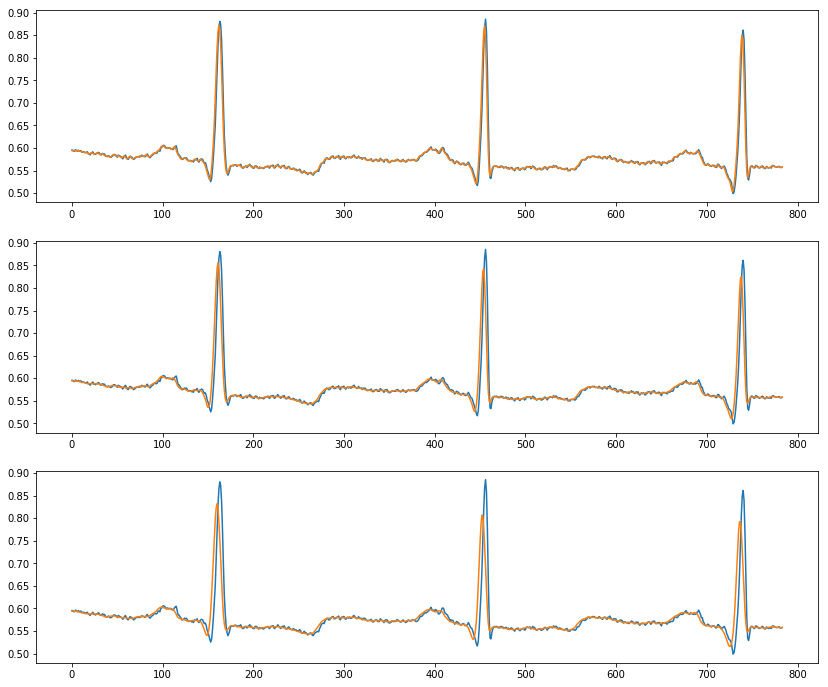

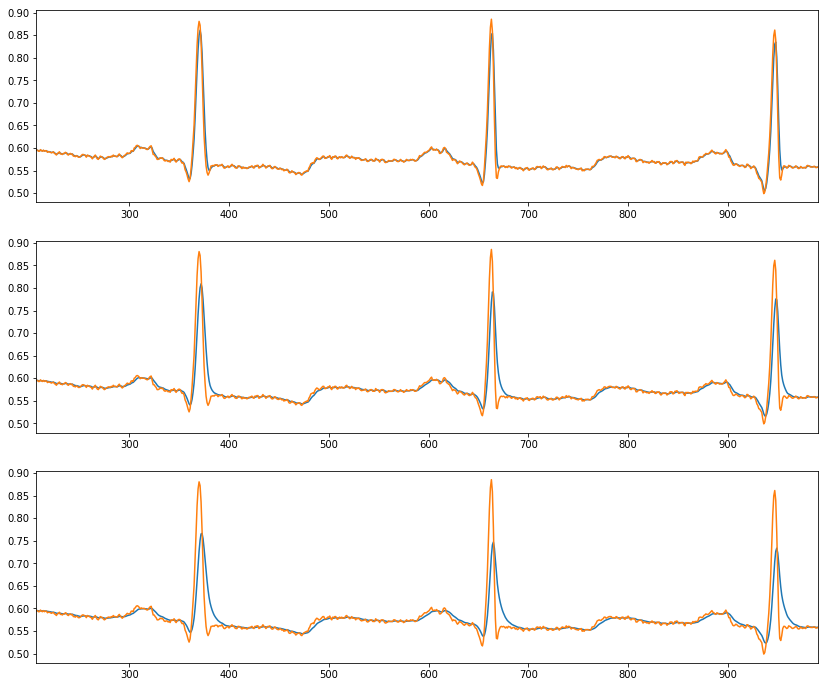

In [164]:
plot(599, 392)

### Autoencoder

In [200]:
def create_encoding_layers(units = [128, 64, 32]):
    return [Dense(u, activation='relu') for u in units]

def create_decoding_layers(units = [64, 128, 784]):
    return [Dense(u, activation='relu' if i < len(units) -1 else 'sigmoid') for i, u in enumerate(units)]

def connect_layers(input, layers):
    for i,l in enumerate(layers):
        if i == 0:
            layer = l(input)
        else:
            layer = l(layer)
    return layer

def create_encoders(input_dim = 784, layers_dim = [128, 64], encoding_dim = 32):    
    normal_input  = Input(shape=(input_dim,))
    encoded_input = Input(shape=(encoding_dim,))

    encoding_layers = create_encoding_layers(layers_dim + [encoding_dim])
    layers_dim.reverse()
    decoding_layers = create_decoding_layers(layers_dim + [input_dim])

    encoded = connect_layers(normal_input, encoding_layers)
    decoded = connect_layers(encoded, decoding_layers)
    semi_decoded = connect_layers(encoded_input, decoding_layers)

    autoencoder = Model(normal_input, decoded)
    encoder = Model(normal_input, encoded)
    decoder = Model(encoded_input, semi_decoded)

    return autoencoder, encoder, decoder

In [180]:
def fit(autoencoder, epochs = 50, loss = 'binary_crossentropy'):
    autoencoder.compile(optimizer='adadelta', loss = loss)
    return autoencoder.fit(x_train, x_train,
                    epochs=epochs,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test), verbose = 0)
    
def check(encoder, decoder):
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.plot(x_test[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.plot(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    return decoded_imgs

In [190]:
x, delta = [], int(784 / 2)
for i in ann[ann['Type'] == 'N']['Sample #']:
    if i >= delta and i < len(sig) - delta:
        s = np.array(sig['MLII'][i - delta:i + delta])        
        s = [np.mean(s[i:i + 5]) for i, _ in enumerate(s)]
        x.append(s)
x_train = np.array(x)        
x_test = np.copy(x_train)

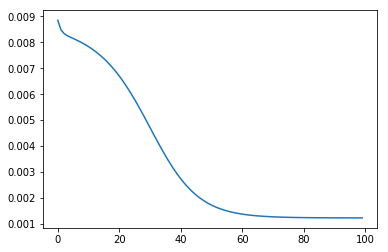

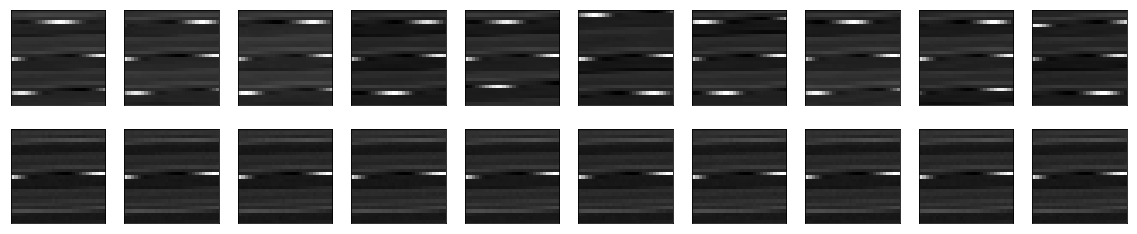

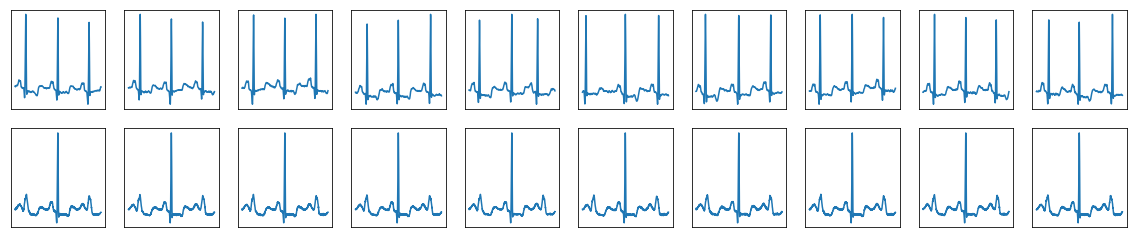

In [191]:
autoencoder, encoder, decoder = create_encoders(784, [256], 32)
loss = fit(autoencoder, epochs=100, loss = 'mse')
plt.plot(loss.history['loss'])
decoded_imgs = check(encoder, decoder)

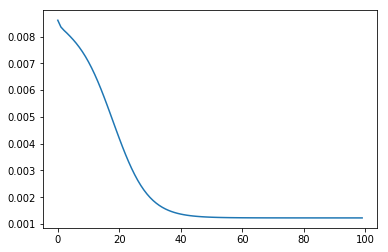

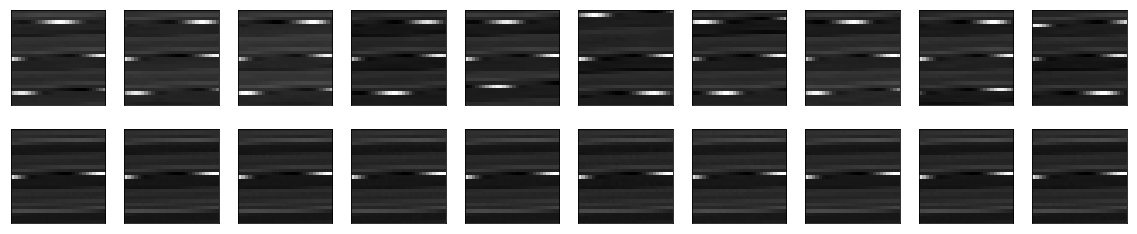

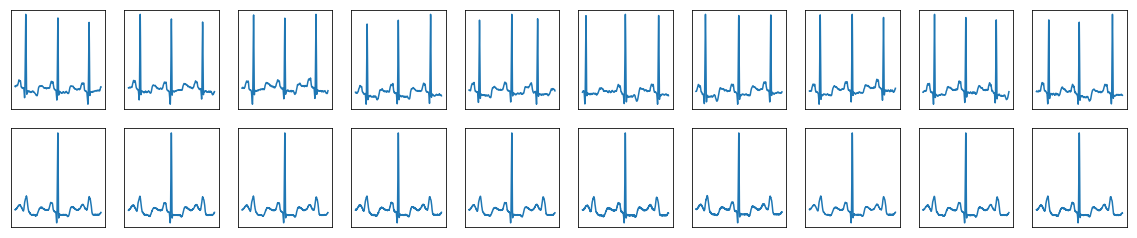

In [207]:
autoencoder, encoder, decoder = create_encoders(784, [256, 128], 64)
loss = fit(autoencoder, epochs=100, loss = 'mse')
plt.plot(loss.history['loss'])
decoded_imgs = check(encoder, decoder)

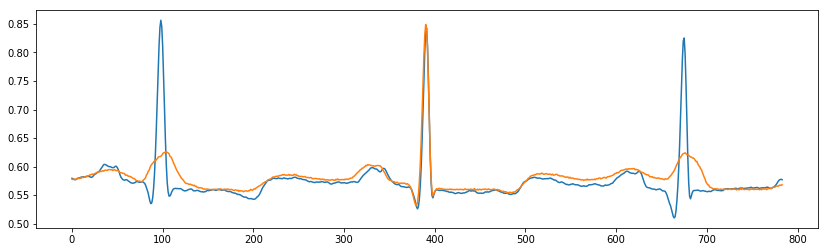

In [208]:
plt.figure(figsize=(14,4))
plt.plot(x_train[0])
plt.plot(decoded_imgs[0])